<h1 style='color:blue' align='center'>Resnet Tensorflow Model (CNN)</h1>



<h2>Step 1: Import required libraries</h2>

In [20]:
import h5py
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.initializers import glorot_uniform
from matplotlib.pyplot import imshow
import keras.backend as K
import imageio
import numpy as np
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

/usr/local/lib/python3.7/dist-packages/keras/backend.py:414: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


<h2>Step 2: Load and prepare the dataset</h2>


In [22]:
def load_dataset():
    train_dataset = h5py.File('datasets/train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:])
    train_set_y_orig = np.array(train_dataset["train_set_y"][:])
    test_dataset = h5py.File('datasets/test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:])
    test_set_y_orig = np.array(test_dataset["test_set_y"][:])
    classes = np.array(test_dataset["list_classes"][:])
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes


def convert_to_one_hot(Y, C):
    return np.eye(C)[Y.reshape(-1)].T

    
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()
X_train = X_train_orig/255.
X_test = X_test_orig/255.
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T

<h2>Step 3: Build/Train the model</h2>


In [23]:
def identity_block(X, f, filters, stage, block):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters
    X_shortcut = X
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    return X

def convolutional_block(X, f, filters, stage, block, s=2):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters
    X_shortcut = X
    X = Conv2D(F1, (1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    X = Conv2D(F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    X = Conv2D(F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)
    X_shortcut = Conv2D(F3, (1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    return X

def ResNet50(input_shape=(64, 64, 3), classes=6):
    X_input = Input(input_shape)
    X = ZeroPadding2D((3, 3))(X_input)
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')
    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')
    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')
    X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')
    X = AveragePooling2D((2, 2), name='avg_pool')(X)
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer=glorot_uniform(seed=0))(X)
    return Model(inputs=X_input, outputs=X, name='ResNet50')

model = ResNet50(input_shape = (64, 64, 3), classes = 6)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, Y_train, epochs = 1, batch_size = 32)
preds = model.evaluate(X_test, Y_test)



4/4 [==============================] - 2s 343ms/step - loss: 6.8395 - accuracy: 0.1667


Input image shape: (1, 64, 64, 3)
class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = 
[[8.6996800e-01 1.6424297e-05 1.3290612e-06 1.2764259e-01 3.8148250e-04
  1.9902696e-03]]


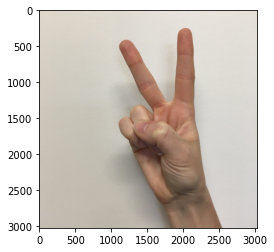

In [24]:
#Test Run using image
img_path = 'images/my_image.jpg'
img = image.load_img(img_path, target_size=(64, 64))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x/255.0
print('Input image shape:', x.shape)
im = imageio.imread(img_path)
imshow(im)
print("class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = ")
print(model.predict(x))

check the model summary

In [25]:
model.summary()
model.save("resnet.h5")

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)   0           ['input_1[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 32, 32, 64)   9472        ['zero_padding2d[0][0]']         
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1[0][0]']                  
                                                                                           

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


<h2>Step 4: Save the model and load it into anther variable</h2>


In [26]:
model = load_model("resnet.h5")
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)   0           ['input_1[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 32, 32, 64)   9472        ['zero_padding2d[0][0]']         
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1[0][0]']                  
                                                                                           

recheck the model summary

In [27]:
model = load_model("resnet.h5")
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)   0           ['input_1[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 32, 32, 64)   9472        ['zero_padding2d[0][0]']         
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1[0][0]']                  
                                                                                           

<h2>Bonus: Learn how to extract the paramters from the model</h2>


In [28]:
print(model.trainable_variables)

[<tf.Variable 'conv1/kernel:0' shape=(7, 7, 3, 64) dtype=float32, numpy=
array([[[[-3.80022228e-02,  4.89154086e-02,  3.68427821e-02, ...,
           1.91486795e-02, -4.23239283e-02,  4.85735796e-02],
         [-2.65103932e-02,  6.01304276e-03,  2.00422239e-02, ...,
           4.25487421e-02, -1.06653748e-02,  1.15345779e-03],
         [-1.81544609e-02,  2.67844815e-02, -3.60081531e-02, ...,
           3.01762335e-02,  8.71323701e-03,  4.39757407e-02]],

        [[ 4.07107025e-02, -1.05192168e-02,  4.08196785e-02, ...,
          -3.74355796e-03, -4.40531969e-03,  6.42094575e-03],
         [-2.62577157e-03, -1.63922217e-02,  7.81184388e-03, ...,
          -2.62413472e-02,  8.80470325e-04,  4.12112586e-02],
         [ 9.34328791e-03,  2.33771261e-02, -2.49053612e-02, ...,
          -2.25632414e-02,  2.86733508e-02,  1.06792087e-02]],

        [[ 8.38729274e-03, -2.89389435e-02,  2.87503656e-02, ...,
           1.70211941e-02,  4.85971291e-03, -5.04807662e-03],
         [-3.95644680e-02, 

<h2>Step 5: Link your recourses</h2>


1- https://github.com/amanchadha/coursera-deep-learning-specialization/tree/master/C4%20-%20Convolutional%20Neural%20Networks/Week%202/ResNets